#  Case-Study: Clustering - Frequent Flyer Program

### Data Science Lifecycle:

1. Problem Definition
2. Data Cleaning
3. Exploratory Data Analysis & Data Visualization
4. Customer segmentation using Clustering

### 1. Problem Definition

NZ Airlines has a frequent flyer program.
 NZA is in possession of a lot of data about the behavior of their FFP customers.
 NZA wishes to develop meaningful customer segments using the FFP behavior data.
 NZA will use the profile and size of customer segments to develop appropriate
marketing and promotional programs to improve their revenues, and satisfy their
customers better.

**Objective**

- The objective is to segment the customers into logical clusters, so that specific marketing and promotional programs can be rolloed out for them.

**Data**
- FrequentFlyerProgram.xls

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ( roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score ) 
import copy as cp
from sklearn import cluster

#Package for hierarchical clustering
from sklearn.cluster import AgglomerativeClustering
# To plot clusters
from scipy.cluster.hierarchy import dendrogram, linkage

# importing PCA for dimentionality reduction
from sklearn.decomposition import PCA

import warnings
import os

In [2]:
# Loading the dataset
os.chdir("D:\Smita\DigitalSkillsAcademy\DATA")
warnings.filterwarnings("ignore")
data = pd.read_excel("FrequentFlyerProgram.xls", 'Data')

In [3]:
# Checking types of variables
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   FFP#                3999 non-null   int64
 1   AwardMiles          3999 non-null   int64
 2   EliteMiles          3999 non-null   int64
 3   PartnerMiles        3999 non-null   int64
 4   PartnerTrans        3999 non-null   int64
 5   FlyingReturnsMiles  3999 non-null   int64
 6   FlightTrans         3999 non-null   int64
 7   EnrollDuration      3999 non-null   int64
dtypes: int64(8)
memory usage: 250.1 KB


In [4]:
data.head()

FFP#  AwardMiles  EliteMiles  PartnerMiles  PartnerTrans  \
0  1072       42040        1000         14189            17   
1  1502       30486           0             0             0   
2  2307       85496           0          2799             7   
3  3652        1884           0             0             0   
4   815       42044        2253         11433            10   

   FlyingReturnsMiles  FlightTrans  EnrollDuration  
0                4034           13            5717  
1                   0            0            5051  
2                2711            6            3820  
3                   0            0              31  
4                   0            0            6140

In [5]:
#Keep copy of original data
data_org = data.copy()

### 2. Data Cleaning

In [6]:
#Checking for missing values
data.isnull().sum() 

FFP#                  0
AwardMiles            0
EliteMiles            0
PartnerMiles          0
PartnerTrans          0
FlyingReturnsMiles    0
FlightTrans           0
EnrollDuration        0
dtype: int64

In [7]:
# Remove duplicates if any
data.duplicated().sum()      #[Observation:No duplicates] 

0

In [8]:
# Drop ID column - FFP#
data = data.drop(columns='FFP#')

### 3. Exploratory data analysis & Data Visualization:

In [9]:
# Summary / Descriptive Statistics of numeric features
data.describe()

AwardMiles    EliteMiles   PartnerMiles  PartnerTrans  \
count  3.999000e+03   3999.000000    3999.000000    3999.00000   
mean   7.360133e+04    144.114529   17144.846212      11.60190   
std    1.007757e+05    773.663804   24150.967826       9.60381   
min    0.000000e+00      0.000000       0.000000       0.00000   
25%    1.852750e+04      0.000000    1250.000000       3.00000   
50%    4.309700e+04      0.000000    7171.000000      12.00000   
75%    9.240400e+04      0.000000   23800.500000      17.00000   
max    1.704838e+06  11148.000000  263685.000000      86.00000   

       FlyingReturnsMiles  FlightTrans  EnrollDuration  
count         3999.000000  3999.000000      3999.00000  
mean           460.055764     1.373593      4118.55939  
std           1400.209171     3.793172      2065.13454  
min              0.000000     0.000000         2.00000  
25%              0.000000     0.000000      2330.00000  
50%              0.000000     0.000000      4096.00000  
75%            311.000000     1.000000      5790.50000  
max          30817.000000    53.000000      8296.00000

In [10]:
data.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                 .background_gradient(subset=['std'], cmap='icefire')\
                 .background_gradient(subset=['50%'], cmap='coolwarm')

**Observation:**
1. Data does not seem to follow continuous distribution, Check through visualization

In [11]:
# Creating list of features and their units to loop thru histogram
features = list(data.columns)
units = ['Miles','Miles','Miles','NoOfTrans','Miles','NoOfTrans','Days']
featureUnits = dict(zip(features,units))

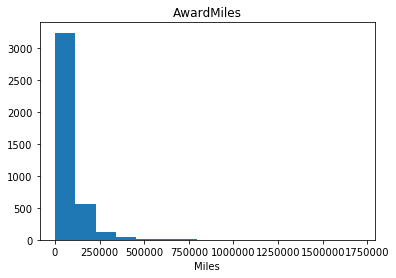

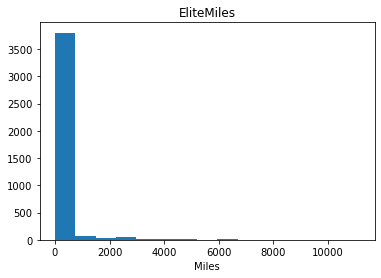

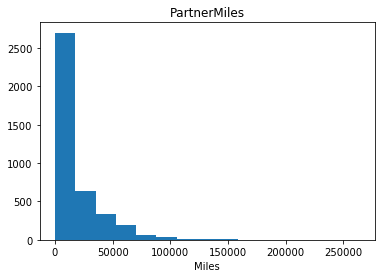

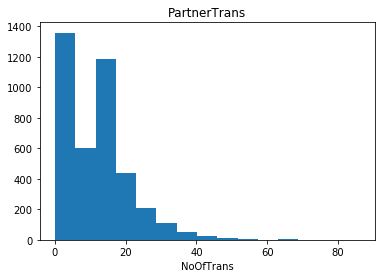

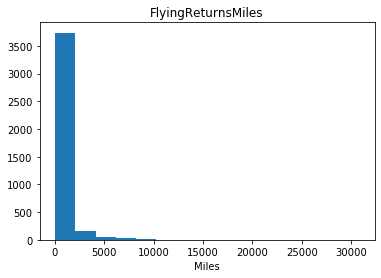

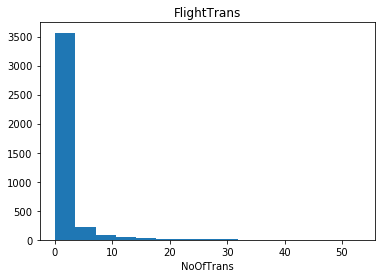

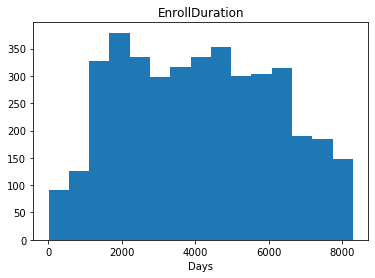

In [12]:
# plot Histogram for each feature
for feature in features:
    plt.hist(data[feature],bins=15)
    plt.xlabel(featureUnits[feature])
    plt.title(feature)
    plt.show()

**Observation:**
1. Most variables show skewed or non-continuous distribution. Data may have outliers.

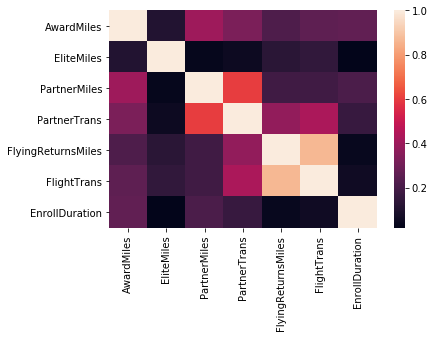

In [13]:
#Check correlation among features
corr = data.corr()
sns.heatmap(corr)
plt.show()

**Observations:**
1. FlightTrans has strong positive correlation with FlyingReturnsMiles
2. FlightTrans has positive correlation with PartnerTrans
3. PartnerMiles has strong positive correlation with PartnerTrans
4. AwardMiles and PartnerMiles have positive correlation
5. EnrollmentDuration does not show strong correlation with any of the feature

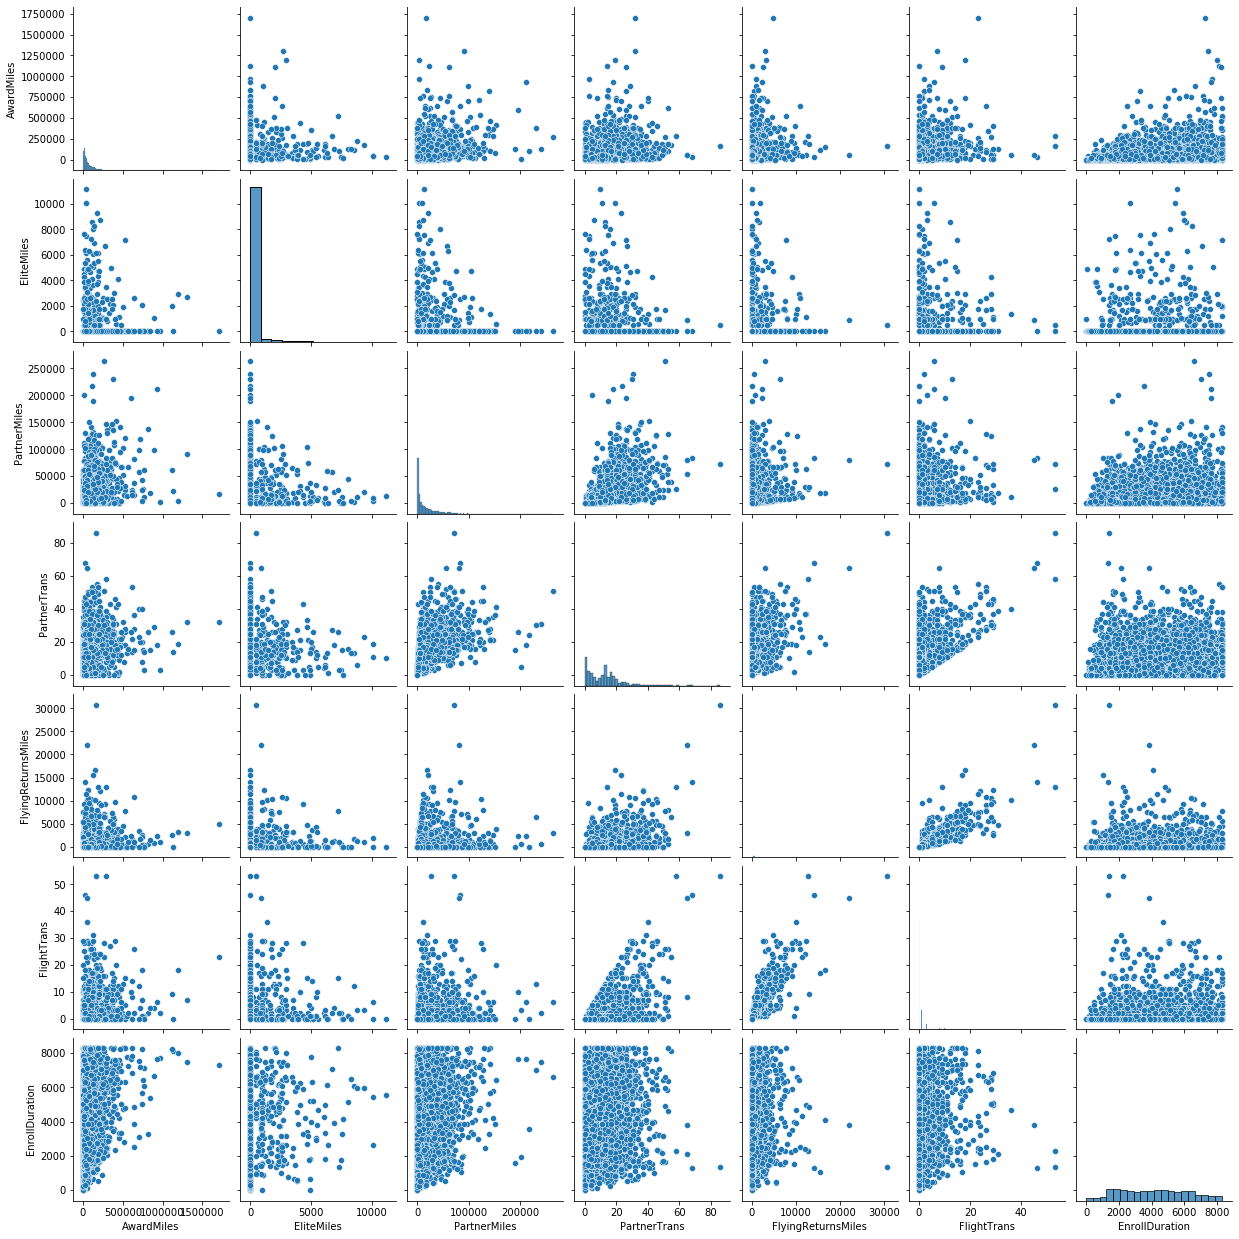

In [14]:
# Visualize relationship among variables thru pairplot
sns.pairplot(data=data)
plt.show()

**Observation:**
1. EliteMiles and EnrollDuration show 3 clusters however not clearly distinguishable.
2. For other variables, clusters are not clearly identifiable. Let's check through K-means clustering.

In [15]:
#Scaling - Standardize data before passing it to K-means clustering algorithm
scaler = StandardScaler()
data1 = scaler.fit_transform(data.values)
data1 = pd.DataFrame(data1, columns = features)

**Observation:**
1. Elbow plot shows that for K=3, distortions(WCSS) are reducing drastically, hence choose optimal K value as 3.

# 1) Model Building - Kmeans Clustering with entire data

In [16]:
# Function to find optimal K value
def find_k(data1):
    # List to store wcss
    distortions=[] 
    # for K values 1 thru 11, measure wcss
    for i in range(1, 11):
        km = cluster.KMeans(n_clusters=i, 
                            init='k-means++',
                            n_init=10,  # make 10 rounds in each iteration to finalize centroid
                            max_iter=300, #Max iterations to finalize centroid
                            random_state=100) 
        km.fit(data1.values)
        distortions.append(km.inertia_) #inertia means wcss
        
    #Plotting K-means elbow plot
    plt.figure(figsize=(7,7))
    plt.plot(range(1,11), distortions, marker='o')
    plt.title('ELBOW PLOT')
    plt.xlabel('Number of Clusters')
    plt.ylabel("Distortion -WCSS")
    plt.show()

#  Function to build K-means clustering model with optimal K value
def build_k_means(data1, k):
    km = cluster.KMeans(n_clusters=k, 
                     init='k-means++',
                     n_init=10,  # make 10 rounds in each iteration to finalize centroid
                     max_iter=300, #Max iterations to finalize centroid
                     random_state=100) 
    km.fit(data1.values)
    # Check cluster labels created by algorithm
    labels = km.labels_  
    return labels

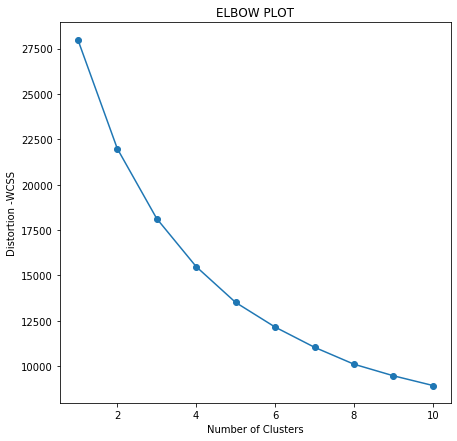

In [17]:
# Find Optimal K value to build k-means model
find_k(data1)

In [18]:
#Optimal K=3, from elbow plot
k=3
labels = build_k_means(data1, k)
labels

array([2, 1, 1, ..., 0, 1, 1])

In [19]:
# Append labels for each data record in dataset
#ccenters = km3.cluster_centers_
data_wl = data.copy()
data_wl['labels']=labels
data_wl['labels'] = data_wl['labels'].astype(str)

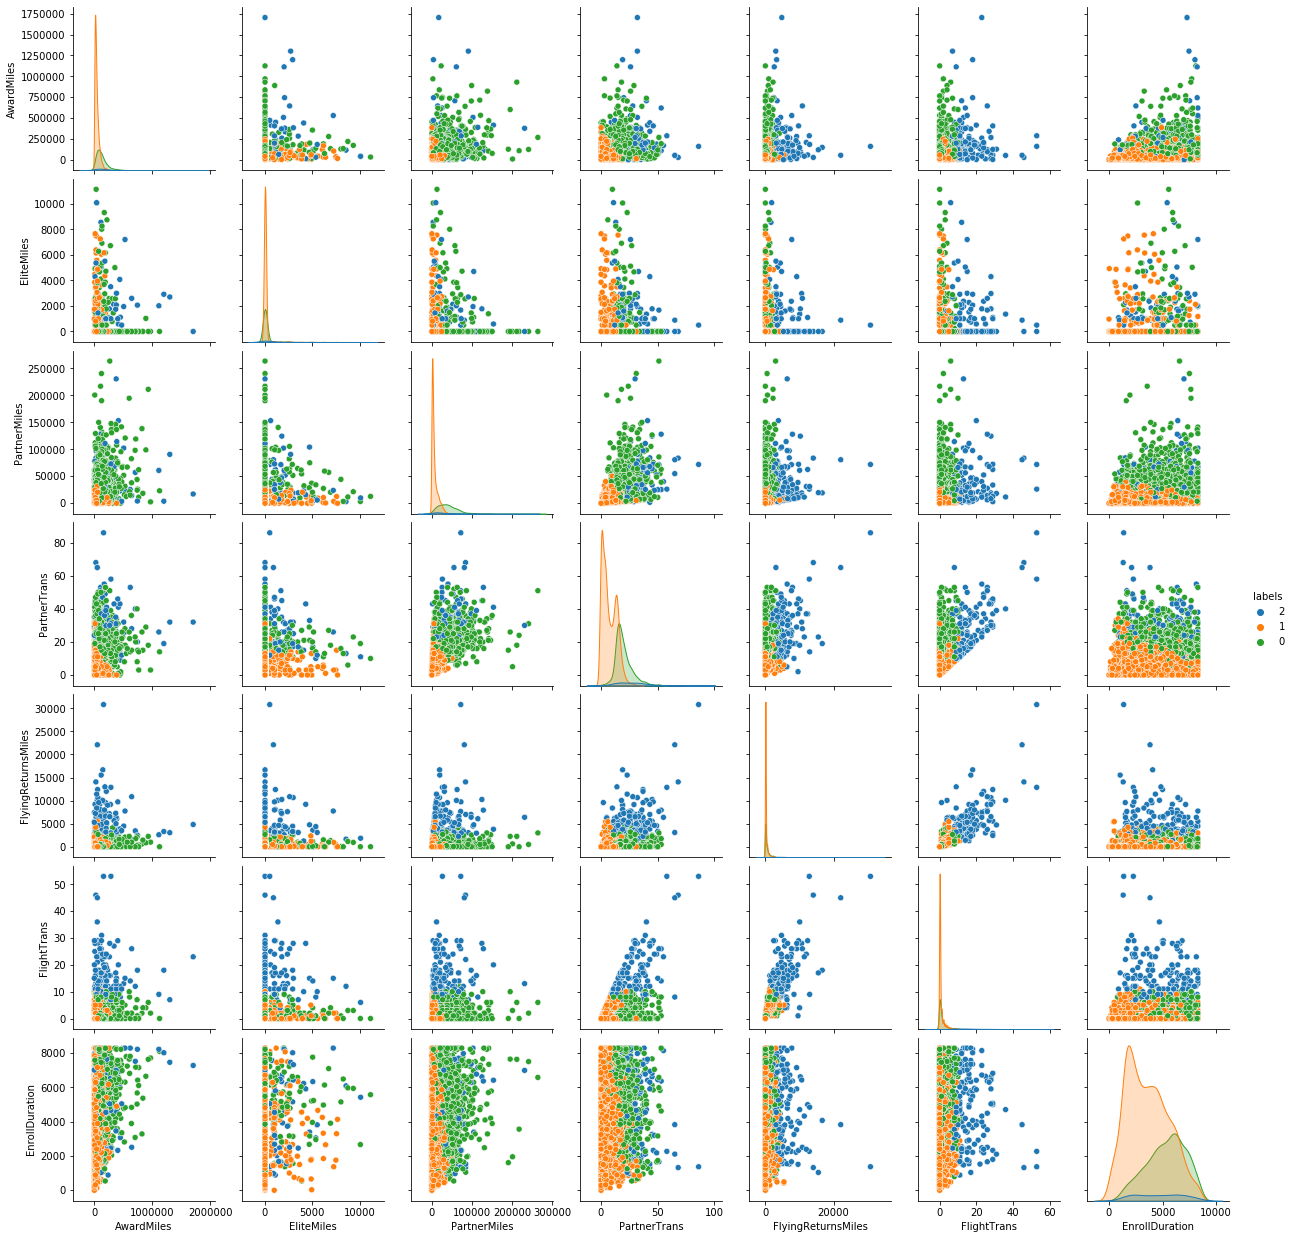

In [20]:
#Visualize clusters created by algorithm
sns.pairplot(data=data_wl, x_vars=features, hue='labels',
             diag_kind='kde')
plt.show()

**Observation:**
1. Pairplot shows 3 clusters not very clearly seperable though. Let's check the feature means for each cluster to draw more understanding about clusters.

In [21]:
# Get cluster means for each featue to draw inference about clusters 
c_df = pd.concat([data[data_wl['labels']=='0'].mean(),
                    data[data_wl['labels']=='1'].mean(),
                    data[data_wl['labels']=='2'].mean()],
                   axis=1) 
c_df.columns = ['cluster1','cluster2','cluster3'] 
c_df

cluster1      cluster2       cluster3
AwardMiles          134271.876607  40282.484293  189373.835443
EliteMiles             187.167952     86.811144     795.924051
PartnerMiles         40624.969152   6006.255797   32228.943038
PartnerTrans            19.646958      7.160060      27.354430
FlyingReturnsMiles     405.382177    183.515333    5544.063291
FlightTrans              1.230506      0.565071      16.113924
EnrollDuration        5276.284490   3582.713538    4636.196203

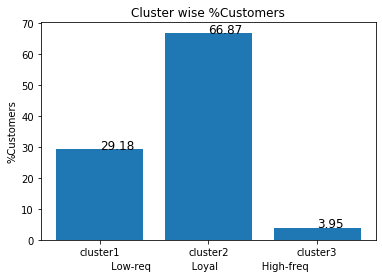

In [22]:
# Checking %of customers in each cluster
cluster_perc = []
total = len(data)
for i in range(0,k):
    c_p =  np.round(len(data[data_wl['labels']==str(i)])/total*100,2)
    cluster_perc.append(c_p)
'''
print("%Customers in cluster 0 :", cluster_perc[0])
print("%Customers in cluster 1 :", cluster_perc[1])
print("%Customers in cluster 2 :", cluster_perc[2])
'''
fig,ax = plt.subplots(figsize=(6,4)) 
ax.bar(c_df.columns, cluster_perc)
plt.title("Cluster wise %Customers")
plt.ylabel("%Customers")
plt.xlabel(" Low-req             Loyal              High-freq")
for index, value in zip(c_df.columns,cluster_perc):
    plt.text(index, value, str(value), fontsize=12)
plt.show()

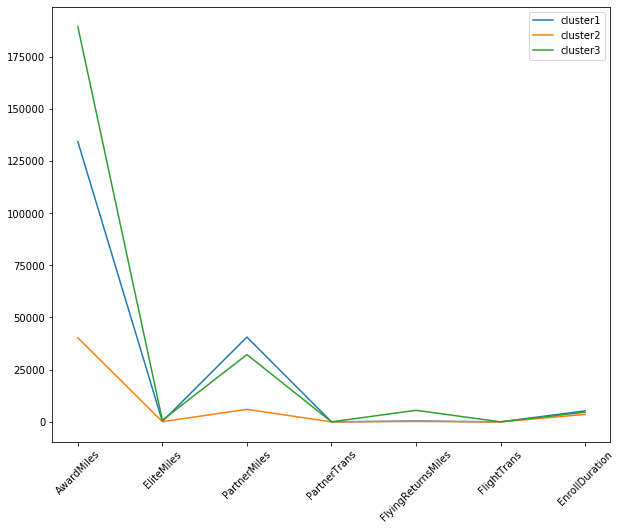

In [23]:
# Plot mean of each feature clusterwise
fig,ax = plt.subplots(figsize=(10,8))
ax.plot(c_df)
plt.xticks(rotation=45)
plt.legend(c_df.columns)
plt.show()

**Observation:**
1. Cluster 1: 
Has 29.18% of total customers. EnrollDuration is highest for this cluster. These customers can be cosidered as 'Loyal customers'. They have more partner transactions(19.6) whereas flight transactions(1.2) are low. They could be using flight services for personal trips. They are earning more miles from partnerservices than from flight travels. They can be targetted to improve flight transactions.
2. Cluster 2: 
Has 66.87% of total customers. The mean EnrollDuration is least in this segment, indicating comparatively 'New or low frequency customers'. Flight transactions are lesser here too compared to partner transactions. Customers here are earning more miles from partner transactions than flght travels. 
3. Cluster 3: 
Has least no. of customers (3.95%). This could represent "High frequency travellers" with much higher miles earned from flight travels compared to other two segments. Here too miles earned by customer from partner transactions are much higher compared to miles earned from flight travels.  

In [24]:
custType = ['Loyal Customer', 'Low-Freq Traveller','High-Freq Traveller']
data_wl['labels'] = labels
data_wl['labels'] = data_wl['labels'].map({0:custType[0],1:custType[1],2:custType[2]})

In [25]:
data_wl

AwardMiles  EliteMiles  PartnerMiles  PartnerTrans  FlyingReturnsMiles  \
0          42040        1000         14189            17                4034   
1          30486           0             0             0                   0   
2          85496           0          2799             7                2711   
3           1884           0             0             0                   0   
4          42044        2253         11433            10                   0   
...          ...         ...           ...           ...                 ...   
3994       40346           0          5412            13                   0   
3995       11449           0         24415            11                   0   
3996       71736           0         53602            25                  50   
3997       41247           0             0             0                   0   
3998       56693        3953         20454            11                   0   

      FlightTrans  EnrollDuration               labels  
0              13            5717  High-Freq Traveller  
1               0            5051   Low-Freq Traveller  
2               6            3820   Low-Freq Traveller  
3               0              31   Low-Freq Traveller  
4               0            6140   Low-Freq Traveller  
...           ...             ...                  ...  
3994            0            1483   Low-Freq Traveller  
3995            0            5864   Low-Freq Traveller  
3996            1            5485       Loyal Customer  
3997            0            2407   Low-Freq Traveller  
3998            0            3893   Low-Freq Traveller  

[3999 rows x 8 columns]

# 2) K-means Clustering - with Outliers removed 

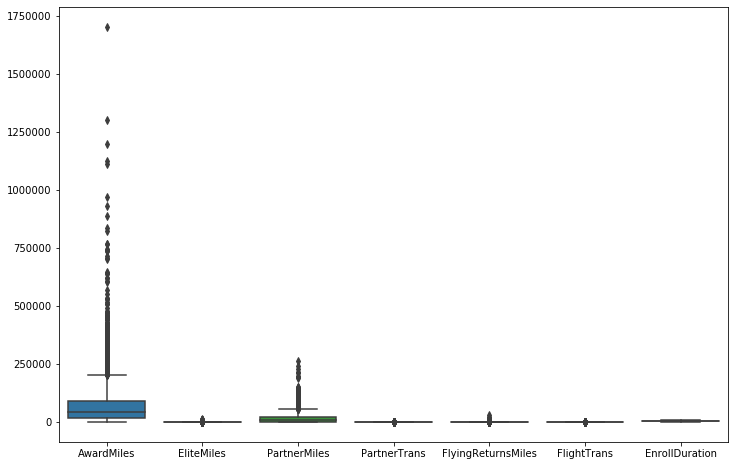

In [26]:
# K-means clustering algorithm uses mean of data points hence sensitive to outliers. Let's check outliers in data.
plt.figure(figsize=(12,8))
sns.boxplot(data=data)
plt.show()

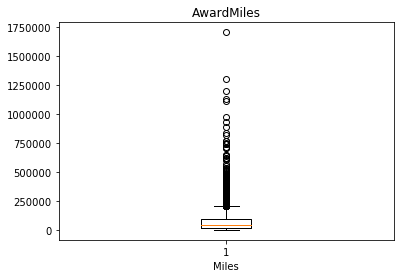

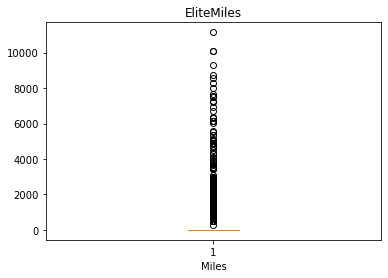

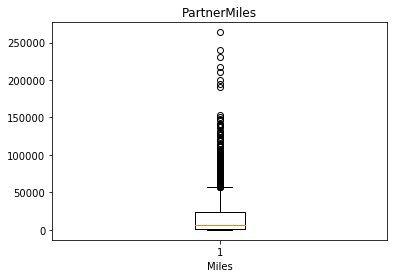

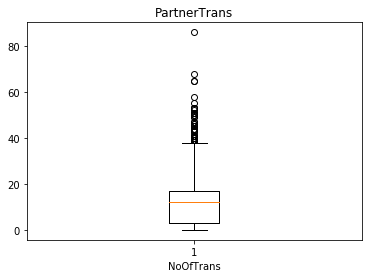

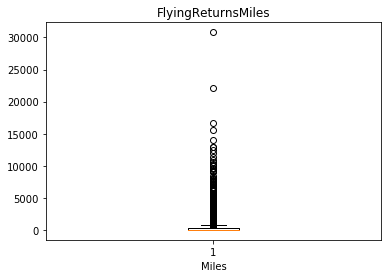

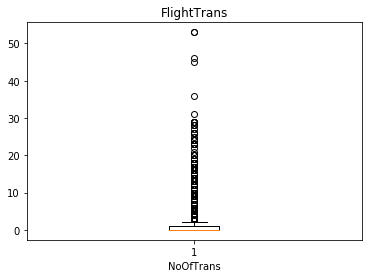

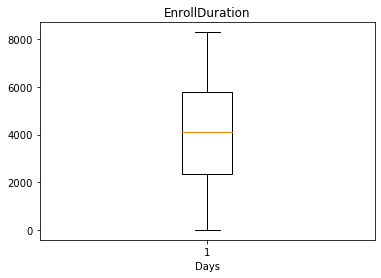

In [27]:
# plot boxplot for each feature
for feature in features:
    plt.boxplot(data[feature])
    plt.xlabel(featureUnits[feature])
    plt.title(feature)
    plt.show()

**Observation:**
1. All features other than EnrollDays indicate outliers. Let's try to treat those.

In [28]:
def treat_outliers(data,feature):
    q1 = data[feature].quantile(0.25)
    q3 = data[feature].quantile(0.75)
    iqr = q3-q1
    ul = q3 + (1.5*iqr)
    ll = q1 - (1.5*iqr)
    print("#Outliers in ",feature," : ", len(data[(data[feature]<ll)|(data[feature]>ul)]))
    newdata = data[(data[feature]>ll)&(data[feature]<ul)]
    return newdata

In [29]:
data.shape

(3999, 7)

In [30]:
# a) Remove outliers from AwardMiles feature
data2 = treat_outliers(data, 'AwardMiles' )
data2.shape

#Outliers in  AwardMiles  :  266


(3733, 7)

In [31]:
# b) Remove outliers from PartnerMiles feature
data2 = treat_outliers(data2, 'PartnerMiles' )
data2.shape

#Outliers in  PartnerMiles  :  260


(3473, 7)

In [32]:
# c) Remove outliers from PartnerTrans feature
data2 = treat_outliers(data2, 'PartnerTrans' )
data2.shape

#Outliers in  PartnerTrans  :  56


(3414, 7)

In [33]:
# d) Remove outliers from FlightTrans feature
data2 = treat_outliers(data2, 'FlightTrans' )
data2.shape

#Outliers in  FlightTrans  :  381


(3033, 7)

In [34]:
'''
# e) Remove outliers from FlyingRetunsMiles feature
datafm = treat_outliers(dataft, 'FlyingReturnsMiles' )
datafm.shape
'''

"\n# e) Remove outliers from FlyingRetunsMiles feature\ndatafm = treat_outliers(dataft, 'FlyingReturnsMiles' )\ndatafm.shape\n"

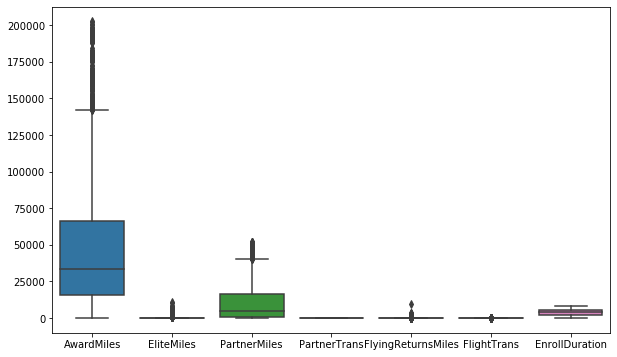

In [35]:
#Plot boxplot of all features
plt.figure(figsize=(10,6))
sns.boxplot(data=data2)
plt.show()

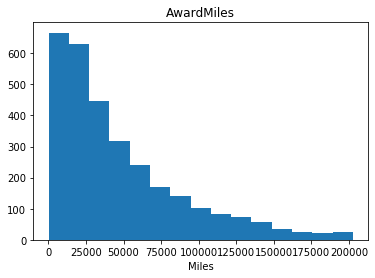

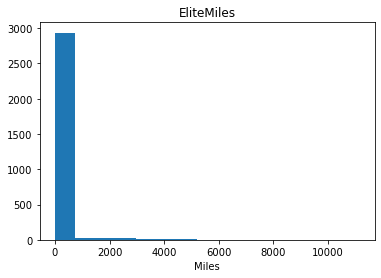

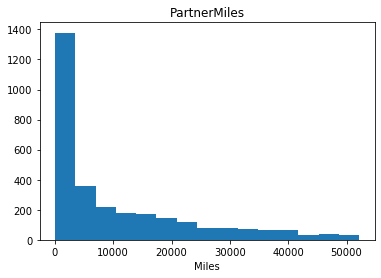

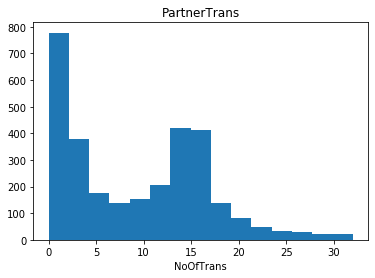

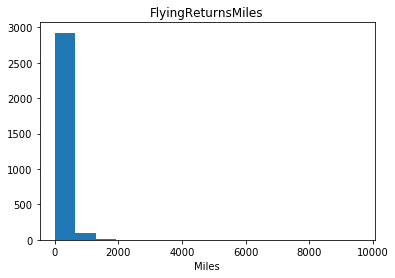

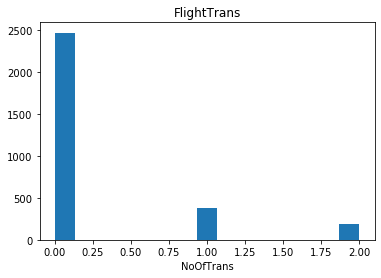

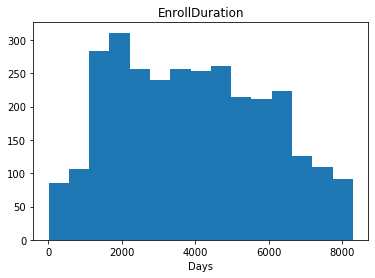

In [36]:
# plot Histogram for each feature
for feature in features:
    plt.hist(data2[feature],bins=15)
    plt.xlabel(featureUnits[feature])
    plt.title(feature)
    plt.show()

**Observation:**
1. After removing outliers many features are showing 2 to 3 segments (FlightTrans, FlyingReturnsMiles, PartnerTrans etc shows 3 segments)

In [37]:
# Keep copy of original data with outliers removed.
data_wo = data2.copy()

In [38]:
#Scaling - Standardize Outliers removed data
scaler = StandardScaler()
data_wo_scaled = scaler.fit_transform(data_wo.values)
data_wo_scaled = pd.DataFrame(data_wo_scaled, columns = features)

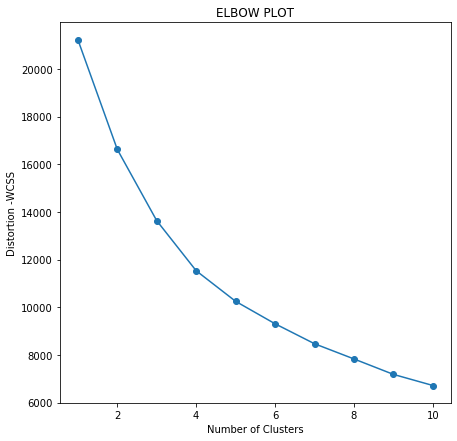

In [39]:
find_k(data_wo_scaled)

In [40]:
# From elbow plot, optimal K value can be taken as 3
k=3
labels = build_k_means(data_wo_scaled,k)

In [41]:
np.unique(labels)

array([0, 1, 2])

In [42]:
# Append labels for each data record in dataset
#ccenters = km3.cluster_centers_
data_wo['labels']=labels
data_wo['labels'] = data_wo['labels'].astype(str)

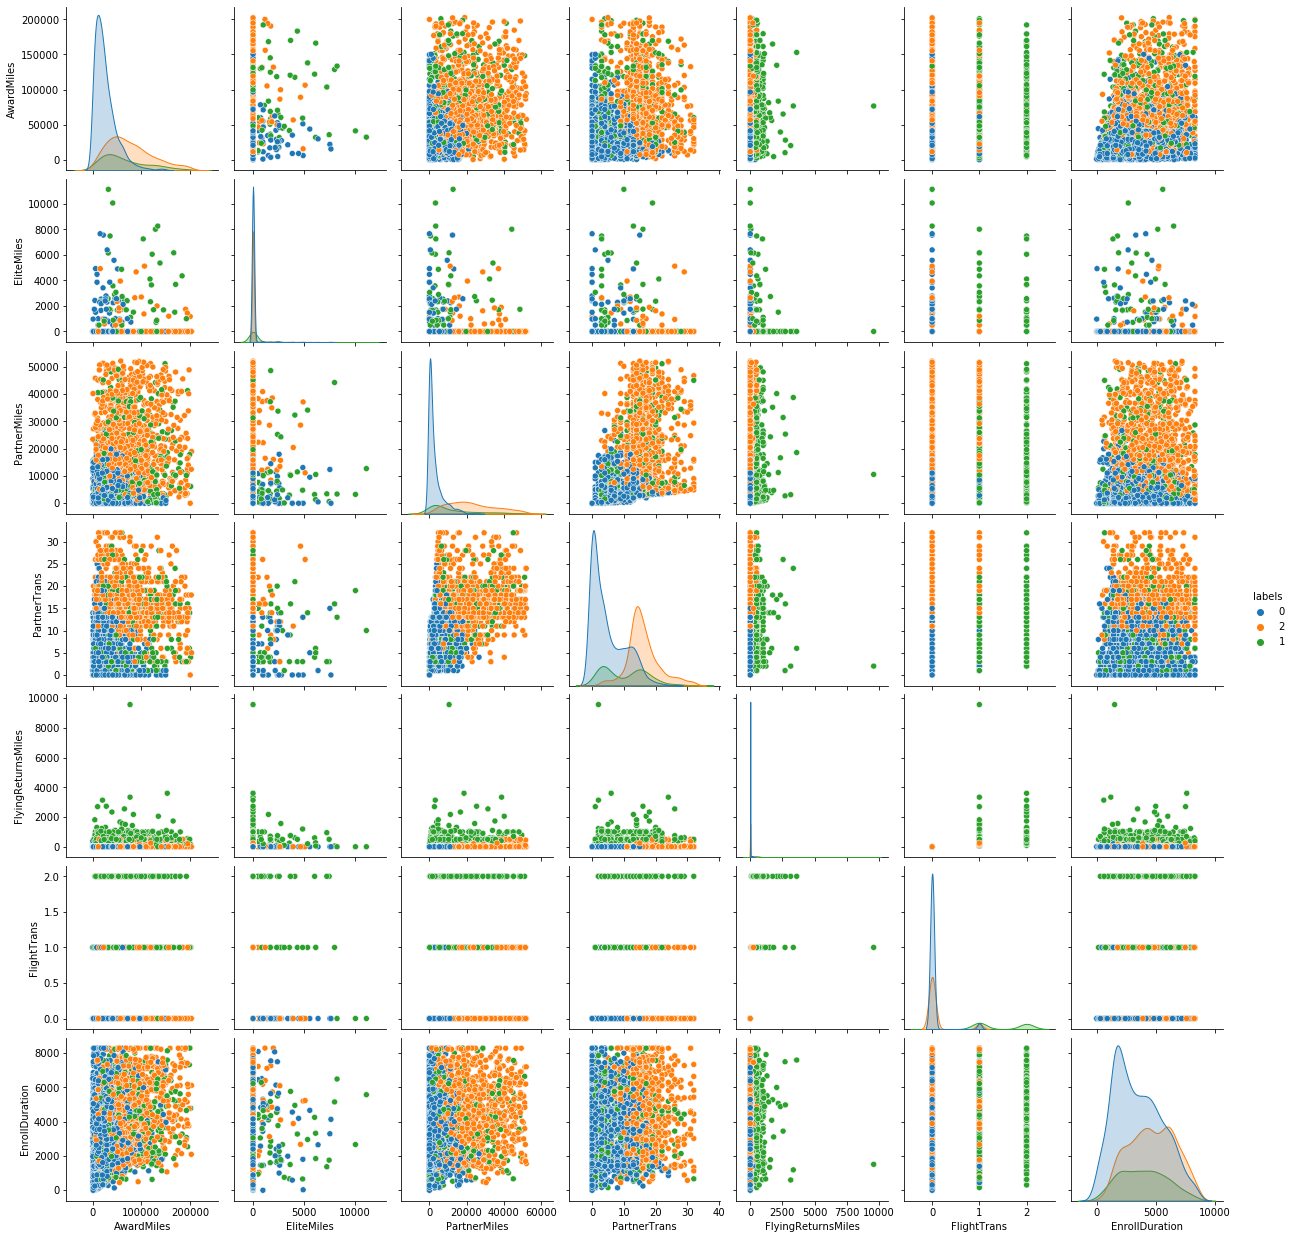

In [43]:
#Visualize clusters created by algorithm
sns.pairplot(data=data_wo, x_vars=features, hue='labels',
             diag_kind='kde')
plt.show()

**Observation:**
1. Pairplot shows 3 clusters, more clearly distinguishable and bit spherical now compared to clusters formed using original data with outliers.

In [44]:
# Get cluster means for each featue to draw inference about clusters 
data_wo1 = data_wo.drop(columns='labels')
c_df1 = pd.concat([data_wo1[data_wo['labels']=='0'].mean(),
                    data_wo1[data_wo['labels']=='1'].mean(),
                    data_wo1[data_wo['labels']=='2'].mean()],
                   axis=1) 
c_df1.columns = ['cluster1','cluster2','cluster3'] 
c_df1

cluster1      cluster2      cluster3
AwardMiles          25425.598784  65782.400966  75943.088296
EliteMiles             65.705167    345.384058     47.869610
PartnerMiles         2766.317933  12192.997585  22847.257700
PartnerTrans            4.873556     10.359903     15.985626
FlyingReturnsMiles      5.860182    595.884058     20.173511
FlightTrans             0.037690      1.439614      0.090349
EnrollDuration       3487.542249   3943.260870   4658.405544

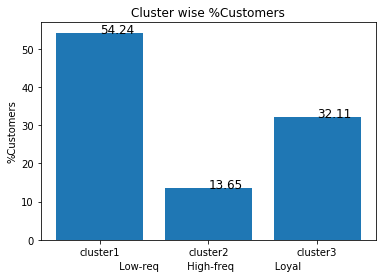

In [45]:
# Checking %of customers in each cluster
cluster_perc = []
total = len(data_wo)
for i in range(0,k):
    c_p =  np.round(len(data_wo[data_wo['labels']==str(i)])/total*100,2)
    cluster_perc.append(c_p)

fig,ax = plt.subplots(figsize=(6,4)) 
ax.bar(c_df1.columns, cluster_perc)
plt.title("Cluster wise %Customers")
plt.ylabel("%Customers")
plt.xlabel(" Low-req         High-freq             Loyal")
for index, value in zip(c_df1.columns,cluster_perc):
    plt.text(index, value, str(value), fontsize=12)
plt.show()

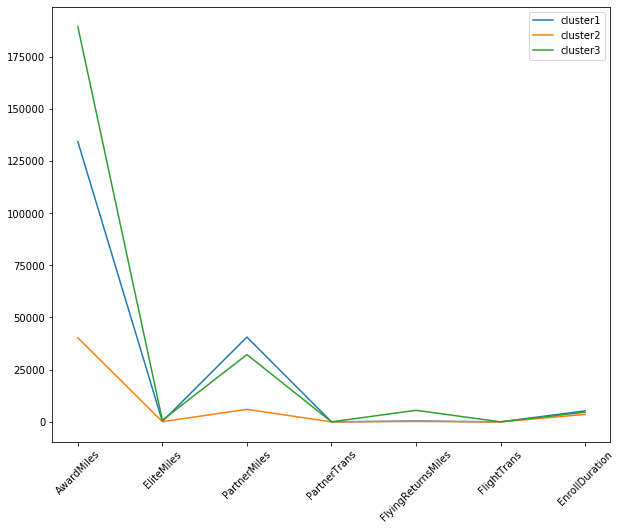

In [46]:
# Plot mean of each feature clusterwise
fig,ax = plt.subplots(figsize=(10,8))
ax.plot(c_df)
plt.xticks(rotation=45)
plt.legend(c_df1.columns)
plt.show()

**Observations:**
1. Cluster 1: 
Has 56% of total customers. The mean EnrollDuration is least in this segment, indicating comparatively "New or low frequency customers". Flight transactions are much lesser compared to partner transactions. Customers here are earning more miles from partner transactions than flght travels. 

2. Cluster 2: 
Has least no. of customers (13%). This could represent "High frequency travellers" with much higher miles earned from flight travels compared to other two segments. Here too miles earned by customer from partner transactions are much higher compared to miles earned from flight travels.  

3. Cluster 3: 
Has 31% of total customers. EnrollDuration is highest for this cluster. These customers can be cosidered as "Loyal customers". They have accumulated most AwardMiles. They have more partner transactions(17) whereas flight transactions are very low. They could be using flight services for personal trips. They are earning more miles from partnerservices than from flight travels. They can be targetted to improve flight transactions.


### Let's assign names to the clusters



In [47]:
custType = ['Low-Freq Traveller','High-Freq Traveller','Loyal Customer']
data_wo['labels'] = labels
data_wo['labels'] = data_wo['labels'].map({0:custType[0],1:custType[1],2:custType[2]})

In [48]:
data_wo

AwardMiles  EliteMiles  PartnerMiles  PartnerTrans  FlyingReturnsMiles  \
1          30486           0             0             0                   0   
3           1884           0             0             0                   0   
4          42044        2253         11433            10                   0   
5          12675           0          4875            25                   0   
7         145214        1692          3500             4                 500   
...          ...         ...           ...           ...                 ...   
3993       20642           0          4977            13                   0   
3994       40346           0          5412            13                   0   
3995       11449           0         24415            11                   0   
3997       41247           0             0             0                   0   
3998       56693        3953         20454            11                   0   

      FlightTrans  EnrollDuration               labels  
1               0            5051   Low-Freq Traveller  
3               0              31   Low-Freq Traveller  
4               0            6140   Low-Freq Traveller  
5               0            1390       Loyal Customer  
7               1            2560  High-Freq Traveller  
...           ...             ...                  ...  
3993            0            1614   Low-Freq Traveller  
3994            0            1483   Low-Freq Traveller  
3995            0            5864       Loyal Customer  
3997            0            2407   Low-Freq Traveller  
3998            0            3893       Loyal Customer  

[3033 rows x 8 columns]

# 3) K-means Clustering - with PCA

In [49]:
# Take copy of data with outliers removed
data_pca = data2.copy()

In [50]:
#Initialize PCA object using scaled, outliers removed data
pca = PCA(n_components=0.95)
pca_data = pca.fit_transform(data_wo_scaled)
pca_data.shape

(3033, 6)

In [51]:
#Storing PCs in dataframe
df_pca = pd.DataFrame(pca_data, columns=['PC1','PC2','pc3','pc4','pc5','pc6'])
print("PCAed Dataset:\n", type(df_pca), df_pca.shape)
df_pca

PCAed Dataset:
 <class 'pandas.core.frame.DataFrame'> (3033, 6)


PC1       PC2       pc3       pc4       pc5       pc6
0    -1.344059  0.081799 -0.157139  1.009650  0.133766  0.263977
1    -2.212236  0.656167  0.047282 -1.288843  0.411969  0.277865
2     0.228152 -0.207008  3.142760  1.147362 -0.952542  0.172333
3    -0.092079 -0.625217 -0.020882 -1.834553 -0.902563 -1.184587
4     1.314933  2.183312  2.331815  0.441194  1.945272 -0.122945
...        ...       ...       ...       ...       ...       ...
3028 -0.769780 -0.191922 -0.002586 -1.186797 -0.188983 -0.394142
3029 -0.550429 -0.252483  0.051849 -1.166015  0.213116 -0.413837
3030  0.254055 -0.930668 -0.238994  0.290544 -1.203333  0.638407
3031 -1.517970  0.301349  0.012126 -0.087428  0.785269  0.222015
3032  0.723516  0.105347  5.820003  0.223357 -0.823643  0.520218

[3033 rows x 6 columns]

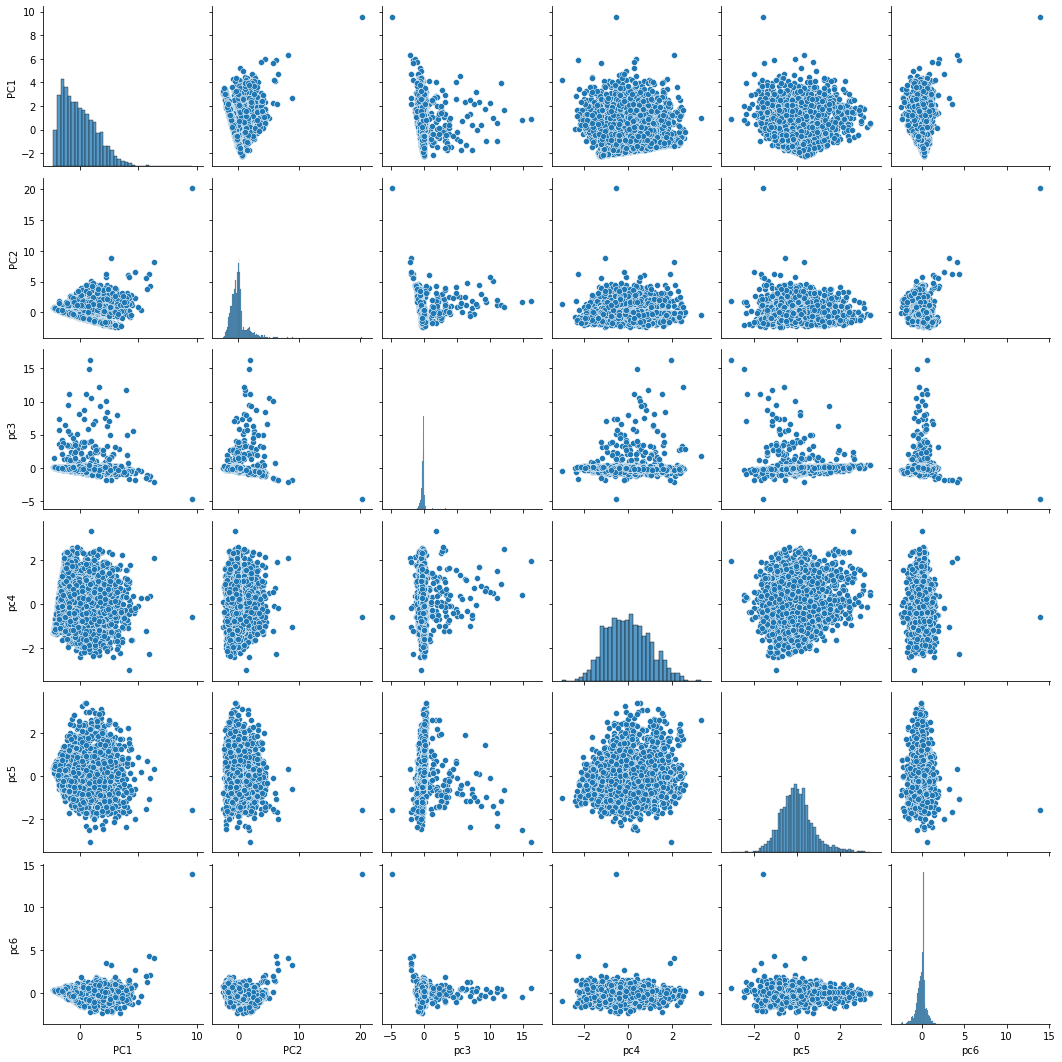

In [52]:
sns.pairplot(df_pca)
plt.show()

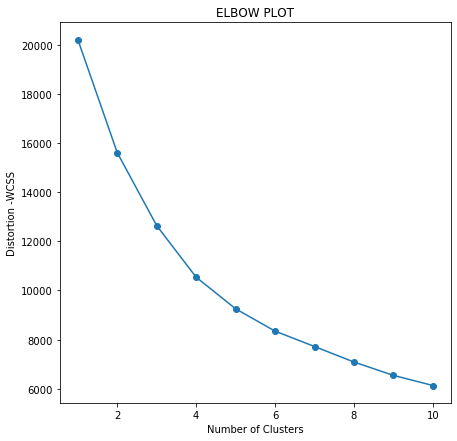

In [53]:
find_k(df_pca)

In [54]:
labels = build_k_means(df_pca,3)
labels

array([1, 1, 0, ..., 0, 1, 0])

In [55]:
np.unique(labels)

array([0, 1, 2])

In [56]:
df_pca['labels']=labels
df_pca['labels'] = df_pca['labels'].astype(str)

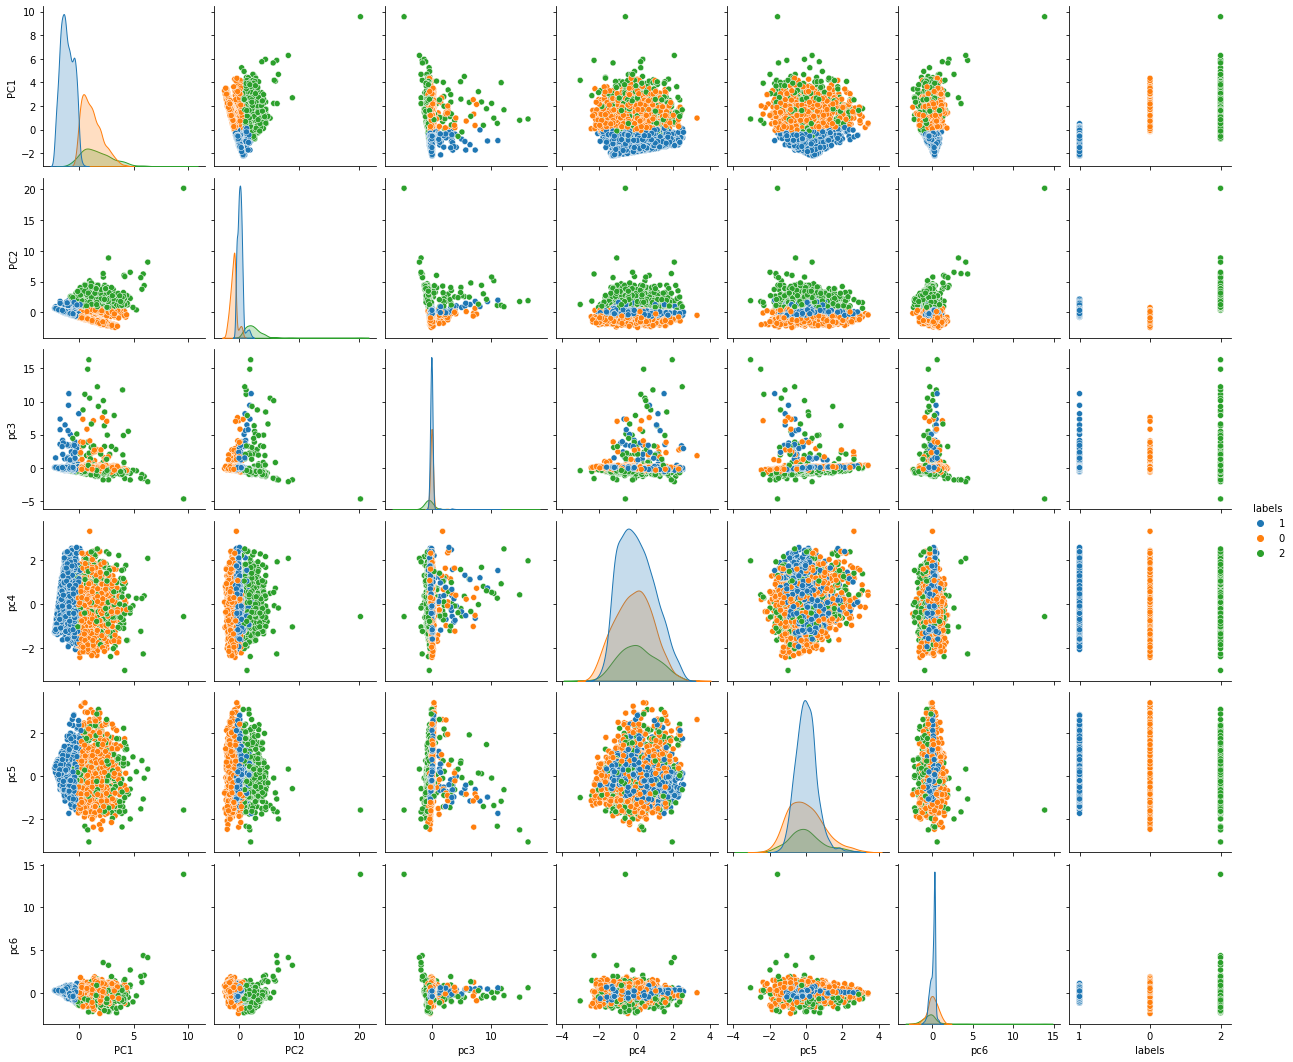

In [57]:
#Visualize clusters created by algorithm
sns.pairplot(data=df_pca, x_vars=df_pca.columns, hue='labels',
             diag_kind='kde')
plt.show()

In [58]:
df_pca

PC1       PC2       pc3       pc4       pc5       pc6 labels
0    -1.344059  0.081799 -0.157139  1.009650  0.133766  0.263977      1
1    -2.212236  0.656167  0.047282 -1.288843  0.411969  0.277865      1
2     0.228152 -0.207008  3.142760  1.147362 -0.952542  0.172333      0
3    -0.092079 -0.625217 -0.020882 -1.834553 -0.902563 -1.184587      0
4     1.314933  2.183312  2.331815  0.441194  1.945272 -0.122945      2
...        ...       ...       ...       ...       ...       ...    ...
3028 -0.769780 -0.191922 -0.002586 -1.186797 -0.188983 -0.394142      1
3029 -0.550429 -0.252483  0.051849 -1.166015  0.213116 -0.413837      1
3030  0.254055 -0.930668 -0.238994  0.290544 -1.203333  0.638407      0
3031 -1.517970  0.301349  0.012126 -0.087428  0.785269  0.222015      1
3032  0.723516  0.105347  5.820003  0.223357 -0.823643  0.520218      0

[3033 rows x 7 columns]

In [59]:
data_pca=data_pca.reset_index()

In [60]:
# Get cluster means for each featue to draw inference about clusters 
c_df3 = pd.concat([data_pca[df_pca['labels']=='0'].mean(),
                    data_pca[df_pca['labels']=='1'].mean(),
                    data_pca[df_pca['labels']=='2'].mean()],
                   axis=1) 
c_df3.columns = ['cluster1','cluster2', 'cluster3'] 
c_df3

cluster1      cluster2      cluster3
index                2019.139442   1997.184098   1982.710660
AwardMiles          74971.469124  25396.279511  66582.030457
EliteMiles             57.859562     54.471560    382.098985
PartnerMiles        22706.426295   2670.988379  11896.967005
PartnerTrans           15.908367      4.789602     10.337563
FlyingReturnsMiles     23.056773      7.110092    612.210660
FlightTrans             0.099602      0.043425      1.459391
EnrollDuration       4647.390438   3481.497859   3930.393401

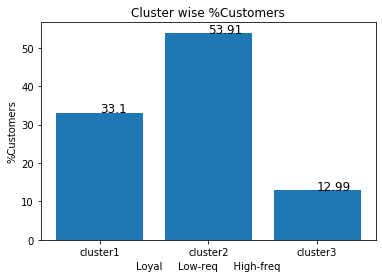

In [61]:
# Checking %of customers in each cluster
cluster_perc = []
total = len(data_pca)
for i in range(0,k):
    c_p =  np.round(len(data_pca[df_pca['labels']==str(i)])/total*100,2)
    cluster_perc.append(c_p)

fig,ax = plt.subplots(figsize=(6,4)) 
ax.bar(c_df3.columns, cluster_perc)
plt.title("Cluster wise %Customers")
plt.ylabel("%Customers")
plt.xlabel("Loyal     Low-req     High-freq")
for index, value in zip(c_df3.columns,cluster_perc):
    plt.text(index, value, str(value), fontsize=12)
plt.show()

**Observations:**
1. Exactly similar to K-means clustering with treated Outliers data.


# 4) Agglomerative Clustering - with Original Data

In [62]:
# Make copy of original and scaled data
data_agg = data.copy()
data_agg_scaled = data1.copy()

In [65]:
# Implement Agglomerative hierarchical clustering
h_cluster = AgglomerativeClustering(n_clusters=3,
                                    affinity='euclidean',
                                    linkage='ward').fit(data_agg_scaled.values)

labels = h_cluster.labels_

In [67]:
data_agg['labels'] = labels 
data_agg['labels'] = data_agg['labels'].astype('str') 

In [77]:
np.unique(labels)

array([0, 1, 2], dtype=int64)

<function matplotlib.pyplot.show(*args, **kw)>

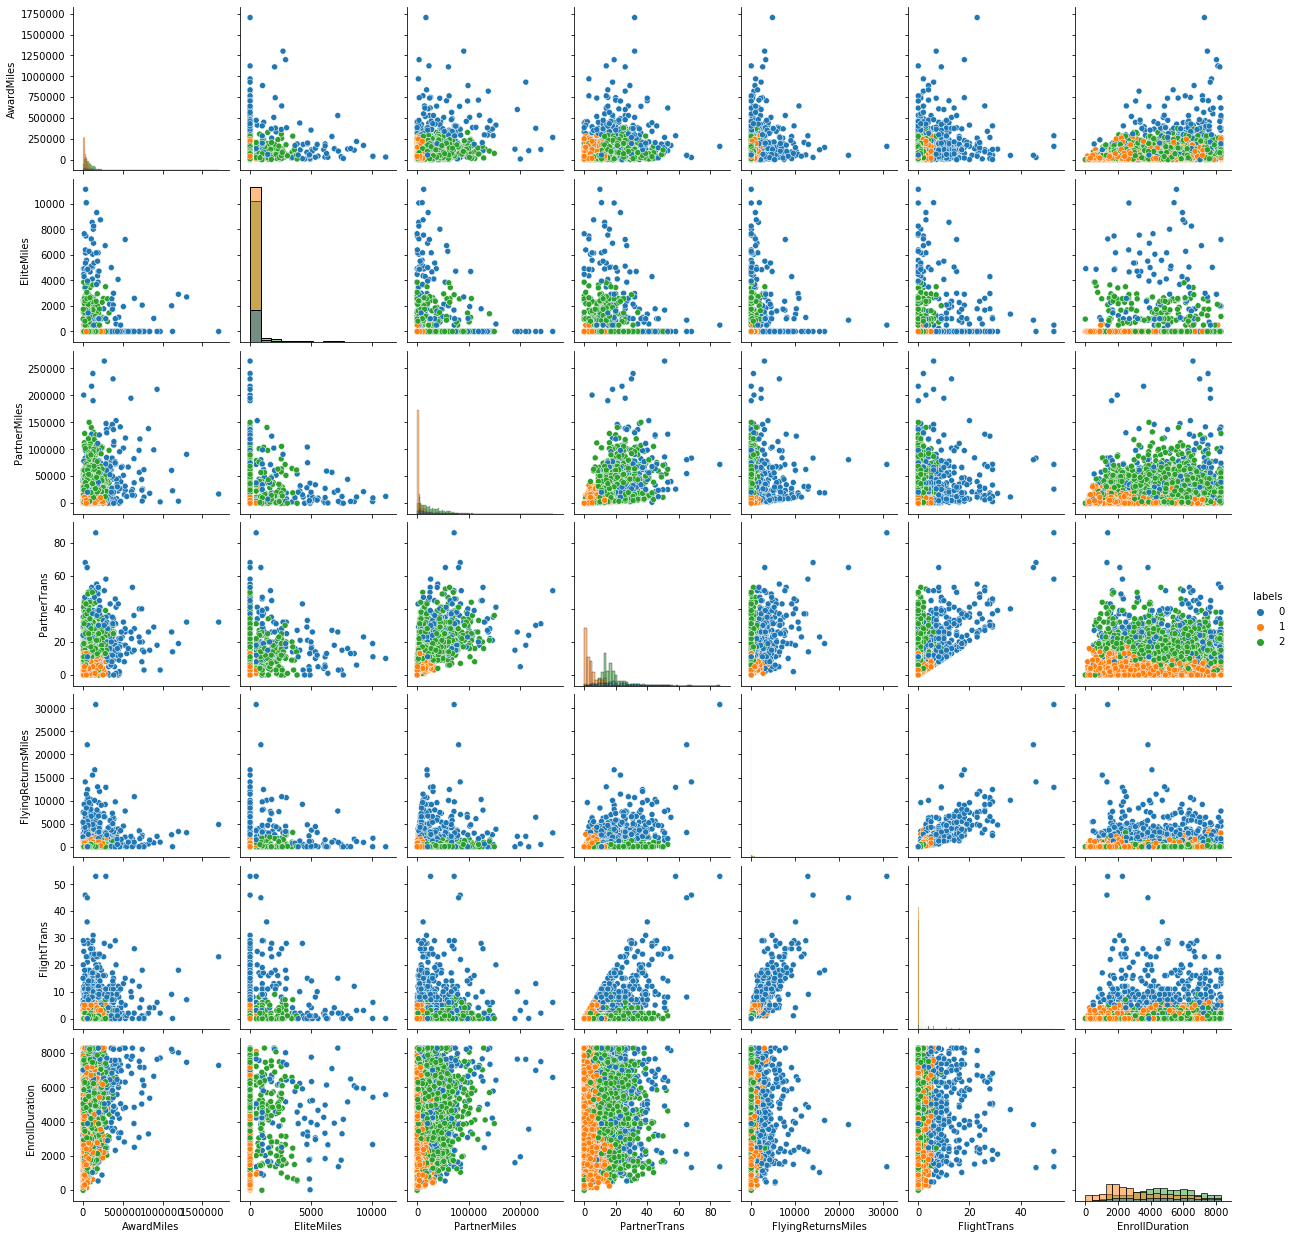

In [68]:
sns.pairplot(data_agg,x_vars = features,y_vars = features,hue='labels',diag_kind='hist') 
plt.show

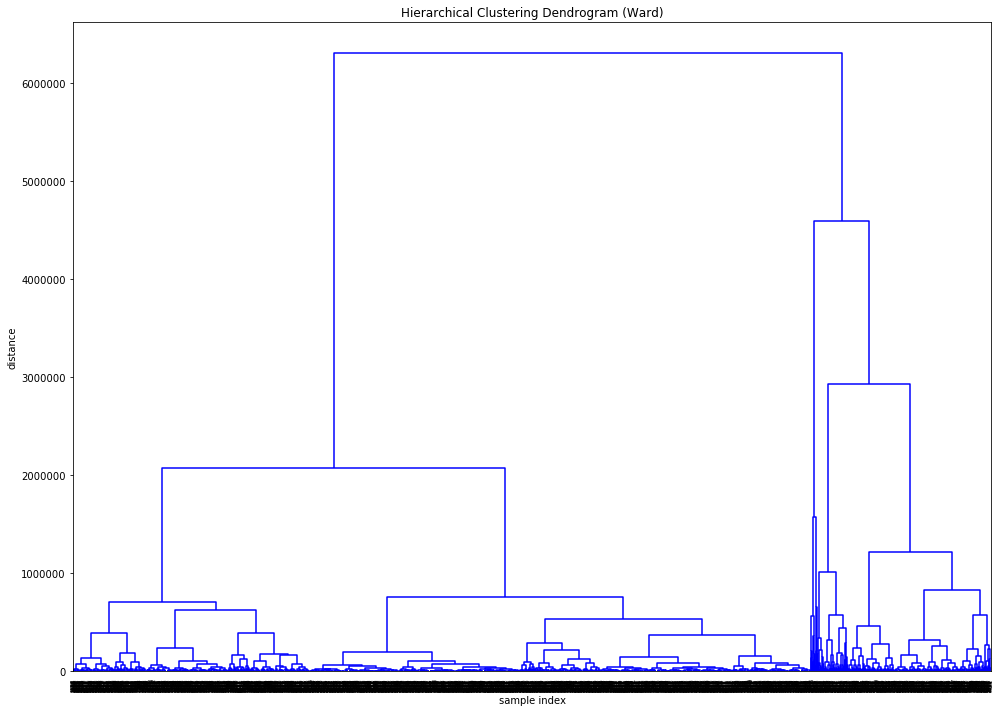

In [69]:
#Plot dendrogram
linkage_matrix = linkage(data_agg, 'ward') 
figure = plt.figure(figsize=(14, 10)) 
dendrogram(linkage_matrix,color_threshold=3) 
plt.title('Hierarchical Clustering Dendrogram (Ward)') 
plt.xlabel('sample index') 
plt.ylabel('distance') 
plt.tight_layout() 
plt.show()

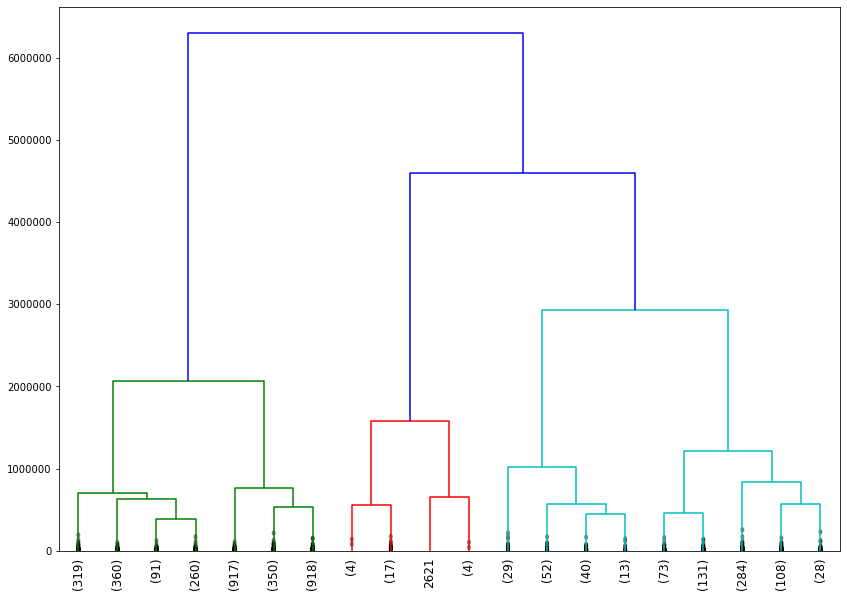

In [70]:
#Plot reduced dendrogram as no. of clusters at bottommost level are not visible
figure = plt.figure(figsize=(14,10)) 
dendrogram(linkage_matrix,     
           truncate_mode='lastp',  # show only the last p merged clusters
           p=20,      # fixing 'p'                  
           leaf_rotation=90.,     
           leaf_font_size=12.,     
           show_contracted=True),  # to get a distribution impression in truncated branches          plt.title('Hierarchical Clustering Dendrogram (Ward, aggrogated)') plt.xlabel('sample index or (cluster size)') plt.ylabel('distance') 
                   
plt.show()

In [80]:
# Get cluster means to get inference about clusters 
data_agg1 = data_agg.drop(columns='labels').copy()

c_df4 = pd.concat([data_agg1[data_agg['labels']=='0'].mean(),
                    data_agg1[data_agg['labels']=='1'].mean(),
                    data_agg1[data_agg['labels']=='2'].mean()],
                   axis=1) 
c_df4.columns = ['cluster1','cluster2','cluster3'] 
c_df4

cluster1      cluster2      cluster3
AwardMiles          191442.796095  37353.074403  79910.013241
EliteMiles             780.622560      0.882288    123.694876
PartnerMiles         33722.685466   3651.923931  26735.156592
PartnerTrans            20.629067      4.246530     16.832470
FlyingReturnsMiles    2893.485900    137.491394    148.672424
FlightTrans              8.329718      0.451416      0.483592
EnrollDuration        4619.863341   3402.970572   4727.468048

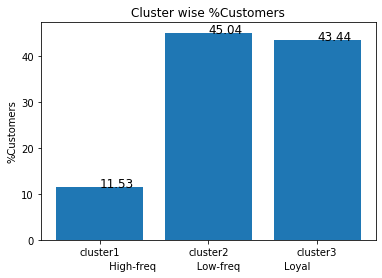

In [81]:
# Checking %of customers in each cluster
cluster_perc = []
total = len(data)
for i in range(0,k):
    c_p =  np.round(len(data_agg1[data_agg['labels']==str(i)])/total*100,2)
    cluster_perc.append(c_p)
'''
print("%Customers in cluster 0 :", cluster_perc[0])
print("%Customers in cluster 1 :", cluster_perc[1])
print("%Customers in cluster 2 :", cluster_perc[2])
'''
fig,ax = plt.subplots(figsize=(6,4)) 
ax.bar(c_df4.columns, cluster_perc)
plt.title("Cluster wise %Customers")
plt.ylabel("%Customers")
plt.xlabel(" High-freq             Low-freq              Loyal")
for index, value in zip(c_df4.columns,cluster_perc):
    plt.text(index, value, str(value), fontsize=12)
plt.show()

# 5) Agglomerative Clustering - with Outliers Removed

In [82]:
# Keep copy of original data with outliers removed.
data_agg_wo = data2.copy()

In [86]:
#Scaling - Standardize Outliers removed data
scaler = StandardScaler()
data_agg_wo_scaled = scaler.fit_transform(data_agg_wo.values)
data_agg_wo_scaled = pd.DataFrame(data_agg_wo_scaled, columns = features)

In [88]:
# Implement Agglomerative hierarchical clustering on outliers removed data
h_cluster = AgglomerativeClustering(n_clusters=3,
                                    affinity='euclidean',
                                    linkage='ward').fit(data_agg_wo_scaled.values)

labels = h_cluster.labels_
data_agg_wo1 = data_agg_wo.copy()
data_agg_wo1['labels'] = labels 
data_agg_wo1['labels'] = data_agg_wo1['labels'].astype('str') 

# CONCLUSION

1. To predict if a customer will opt for Term deposit or no, we used various classification models on the given data viz. Logistic Regression, LDA, KNN, Decision Tree, Random Forest and SVM. 
2. We used logit function to identify the important parameters which may impact prediction and ran all the models with reduced set of parameters.
3. We also used PCA method to identify the principal components (important features) impacting prediction. However as most features are categorical, PCA may not give substantially better results.
4. Cross validation was used to get actual accuracy of the model, by passing it all sections of data section by section. 
5. We want model with higher Recall value in this case study as we do not want model to miss out on positive cases i.e. predict positive (customer will opt for term deposit) if actuals are positive. 
6. After trying various combinations and models, we found that Random Forest classifier is giving highest accuracy (80.33) and highest recall (78.94) among all models. 
